In [1]:
!!pip install -q git+https://github.com/keras-team/keras-hub.git
!!pip install -q --upgrade keras  # Upgrade to Keras 3.

[]

In [2]:
import os

# Set Keras backend
os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

# Standard Library imports
import json
import math

# Third-party imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import keras
from keras import losses, ops, optimizers, metrics
from keras.optimizers import schedules
from keras.applications.imagenet_utils import decode_predictions
from sklearn.model_selection import KFold
import keras_hub


In [3]:
# Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 4
NUM_FOLDS = 5
EPOCHS = 50
GAMMA = 2.0


In [4]:
classifier = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet")

100%|██████████| 840/840 [00:00<00:00, 1.77MB/s]


100%|██████████| 3.54k/3.54k [00:00<00:00, 3.88MB/s]


100%|██████████| 98.1M/98.1M [00:02<00:00, 49.1MB/s]


100%|██████████| 90.2M/90.2M [00:01<00:00, 51.3MB/s]


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define the learning rate schedule

In [ ]:
def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )
        return ops.where(step > self.total_steps, 0.0, lr)

# Load Dataset and Show

In [ ]:
def plot_image_gallery(images, titles=None, num_cols=3, figsize=(10, 10)):
    # Ensure images are in the correct format for display
    images = images.numpy()  # Convert tensor to NumPy array

    num_images = images.shape[0]
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten to iterate easily

    for i, ax in enumerate(axes):
        if i < num_images:
            # Plot each image individually
            ax.imshow(images[i])  # Display each image
            ax.axis("off")  # Remove axis
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=10)
        else:
            ax.axis("off")  # Turn off axis if there are more subplots than images

    plt.tight_layout()
    plt.show()

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/3D/tt/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,
    label_mode='int'
)

Found 336 files belonging to 4 classes.


# preprocessing

In [7]:
# Convert the dataset to a list of (image, label) pairs
images = []
labels = []
for image, label in dataset:
    images.append(image[0])  # Remove the extra batch dimension here
    labels.append(label)

# Convert lists to numpy arrays for KFold processing
images = np.array(images)
labels = np.array(labels)

# Define the gamma transformation function
def apply_gamma(image, gamma=1.0):
    # Apply gamma correction by adjusting pixel values
    gamma_corrected = tf.image.adjust_gamma(image, gamma=gamma)
    return gamma_corrected

# KFold

In [8]:
# Define KFold cross-validator
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
fold_no = 1
val_accuracies = []
best_val_accuracy = 0  # Track the best validation accuracy
best_weights = None    # Placeholder for best model weights

train_accuracy_history = []
val_accuracy_history = []

for train_index, val_index in kf.split(images):
    print(f"\nTraining fold {fold_no}...")

    # Split images and labels into training and validation sets for this fold
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Convert them back to TensorFlow datasets with gamma transformation applied
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.map(lambda x, y: (apply_gamma(x, gamma=GAMMA) / 255.0, y))  # Normalize after gamma
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.map(lambda x, y: (apply_gamma(x, gamma=GAMMA) / 255.0, y))  # Normalize after gamma
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    # Define the model using the Functional API
    base_model = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet", num_classes=4, trainable=True)
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.SGD(learning_rate=0.01),
        metrics=["accuracy"]
    )

    # Train the model on this fold
    history = model.fit(train_dataset, epochs=25, validation_data=val_dataset)

    # Append accuracy histories for each fold
    train_accuracy_history.append(history.history['accuracy'])
    val_accuracy_history.append(history.history['val_accuracy'])

    # Get the validation accuracy for this fold
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy}")

    # Check if this fold's model is the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights = model.get_weights()  # Save the weights of the best model

    fold_no += 1


Training fold 1...
Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.2862 - loss: 1.3910 - val_accuracy: 0.1765 - val_loss: 1.4132
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - accuracy: 0.3401 - loss: 1.3691 - val_accuracy: 0.5588 - val_loss: 1.3279
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.4301 - loss: 1.3334 - val_accuracy: 0.5294 - val_loss: 1.3070
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4337 - loss: 1.3393 - val_accuracy: 0.5147 - val_loss: 1.2957
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.4326 - loss: 1.3055 - val_accuracy: 0.5147 - val_loss: 1.2474
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.4334 - loss: 1.2791 - val_accuracy: 0.5147 - val_loss: 1.2465
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 287ms/step - accuracy: 0.4418 - loss: 1.2645 - val_accuracy: 0.5147 - val_loss: 1.2528
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.4334 - loss: 1.2554 - val_accuracy:

In [9]:
# Convert lists to numpy arrays for easier averaging
train_accuracy_history = np.array(train_accuracy_history)
val_accuracy_history = np.array(val_accuracy_history)

Plot training and validation accuracy for each fold

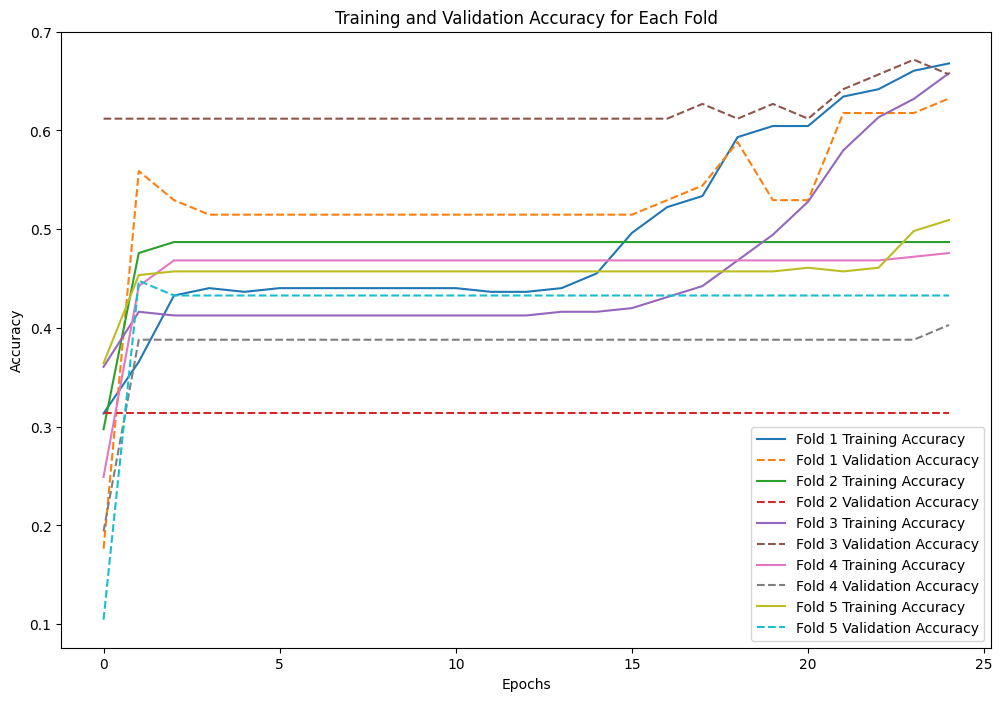

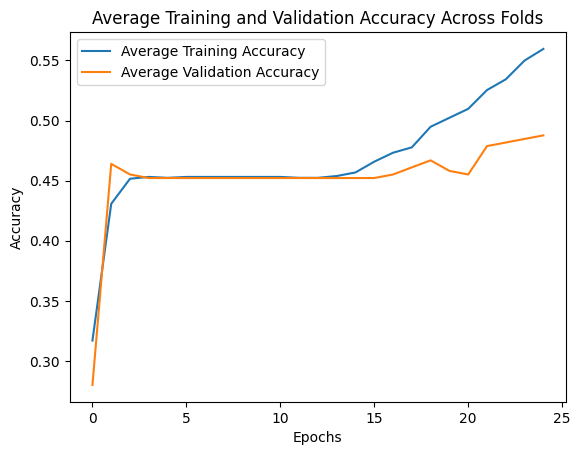

In [10]:
# Plot training and validation accuracy for each fold
plt.figure(figsize=(12, 8))
for i in range(NUM_FOLDS):
    plt.plot(train_accuracy_history[i], label=f'Fold {i+1} Training Accuracy')
    plt.plot(val_accuracy_history[i], label=f'Fold {i+1} Validation Accuracy', linestyle='--')

plt.title('Training and Validation Accuracy for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Calculate mean accuracy across folds for each epoch
mean_train_accuracy = np.mean(train_accuracy_history, axis=0)
mean_val_accuracy = np.mean(val_accuracy_history, axis=0)

# Plot average training and validation accuracy
plt.figure()
plt.plot(mean_train_accuracy, label='Average Training Accuracy')
plt.plot(mean_val_accuracy, label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Final Model

In [11]:
# After cross-validation, create a new model and load the best weights
final_model = keras.Model(inputs=inputs, outputs=outputs)  # Same architecture as before
final_model.set_weights(best_weights)  # Load best weights from cross-validation

# Compile the final model
final_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"]
)

# Combine the full dataset for fine-tuning with gamma transformation applied
full_train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
full_train_dataset = full_train_dataset.map(lambda x, y: (apply_gamma(x, gamma=GAMMA) / 255.0, y))
full_train_dataset = full_train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Fine-tune the model on the full dataset
history = final_model.fit(full_train_dataset, epochs=45)

Epoch 1/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step - accuracy: 0.6163 - loss: 0.8559
Epoch 2/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.6296 - loss: 0.8279
Epoch 3/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.6504 - loss: 0.8037
Epoch 4/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.6629 - loss: 0.7726
Epoch 5/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.6788 - loss: 0.7468
Epoch 6/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.6974 - loss: 0.7187
Epoch 7/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.6976 - loss: 0.6962
Epoch 8/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.7085 - loss: 0.6766
Epoch 9/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.7122 - loss: 0.6614
Epoch 10/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.7356 - loss: 0.6422
Epoch 11/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.7505 - loss: 0.6310
Epoch 12/45
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step 

# Plot training accuracy and loss for the final model


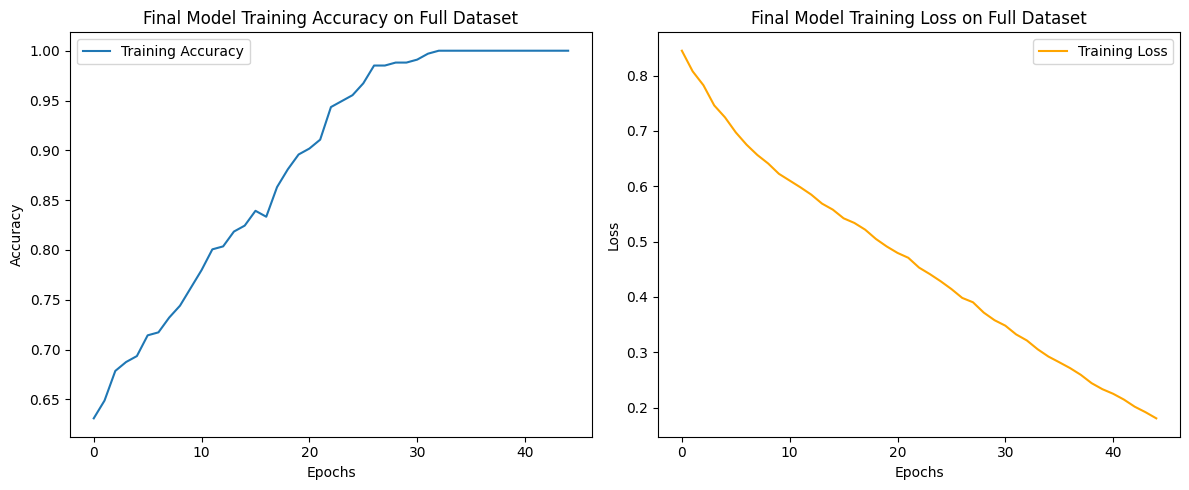

In [12]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Final Model Training Accuracy on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title('Final Model Training Loss on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Load the test dataset from directory


In [13]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/3D/ttt/ttt",  # Path to test dataset
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'  # Use 'int' labels to match the training dataset
)

# Apply gamma transformation and normalize the test dataset
test_dataset = test_dataset.map(lambda x, y: (apply_gamma(x, gamma=GAMMA) / 255.0, y))  # Apply gamma and normalize

# Evaluate the final model on the test dataset
test_loss, test_accuracy = final_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 55 files belonging to 4 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.8250 - loss: 0.6747

Test Loss: 0.7091848254203796
Test Accuracy: 0.7999999523162842


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/3D/tt/tt",
    image_size=IMAGE_SIZE,
    batch_size=1,
    label_mode='int'
)

images = []
labels = []
for image, label in dataset:
    images.append(image[0])  # Remove the extra batch dimension here
    labels.append(label)

# Convert lists to numpy arrays for KFold processing
images = np.array(images)
labels = np.array(labels)


def preprocess_inputs(image, label):
    image = tf.image.resize(image, [224, 224])  # Resize if not already done
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]
    return image, label

Found 32 files belonging to 4 classes.


In [ ]:
# Define KFold cross-validator
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
fold_no = 1
val_accuracies = []
best_val_accuracy = 0  # Track the best validation accuracy
best_weights = None    # Placeholder for best model weights

train_accuracy_history = []
val_accuracy_history = []

for train_index, val_index in kf.split(images):
    print(f"\nTraining fold {fold_no}...")

    # Split images and labels into training and validation sets for this fold
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Convert them back to TensorFlow datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))  # Normalize without resizing
    train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y))  # Normalize without resizing
    val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    # Define the model using the Functional API

    base_model = keras_hub.models.ImageClassifier.from_preset("resnet_v2_50_imagenet", num_classes=4 , trainable=True)
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs)
    outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        loss="sparse_categorical_crossentropy",
        # optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
        optimizer=keras.optimizers.SGD(learning_rate=0.01),
        metrics=["accuracy"]
    )

    # Train the model on this fold
    history = model.fit(train_dataset, epochs=50, validation_data=val_dataset)

    # Append accuracy histories for each fold
    train_accuracy_history.append(history.history['accuracy'])
    val_accuracy_history.append(history.history['val_accuracy'])

    # Get the validation accuracy for this fold
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Fold {fold_no} - Validation Accuracy: {val_accuracy}")

    # Check if this fold's model is the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_weights = model.get_weights()  # Save the weights of the best model

    fold_no += 1


Training fold 1...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.2000 - loss: 1.3805 - val_accuracy: 0.2857 - val_loss: 1.4342
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step - accuracy: 0.2800 - loss: 1.3694 - val_accuracy: 0.0000e+00 - val_loss: 1.4147
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.4400 - loss: 1.3689 - val_accuracy: 0.1429 - val_loss: 1.3877
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.2000 - loss: 1.3845 - val_accuracy: 0.1429 - val_loss: 1.3723
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.2800 - loss: 1.3795 - val_accuracy: 0.2857 - val_loss: 1.3740
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.2400 - loss: 1.3766 - val_accuracy: 0.2857 - val_loss: 1.3802
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.2400 - loss: 1.3730 - val_accuracy: 0.1429 - val_loss: 1.3759
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2800 - loss: 1.3667 - val_accura

In [ ]:
# Convert lists to numpy arrays for easier averaging
train_accuracy_history = np.array(train_accuracy_history)
val_accuracy_history = np.array(val_accuracy_history)

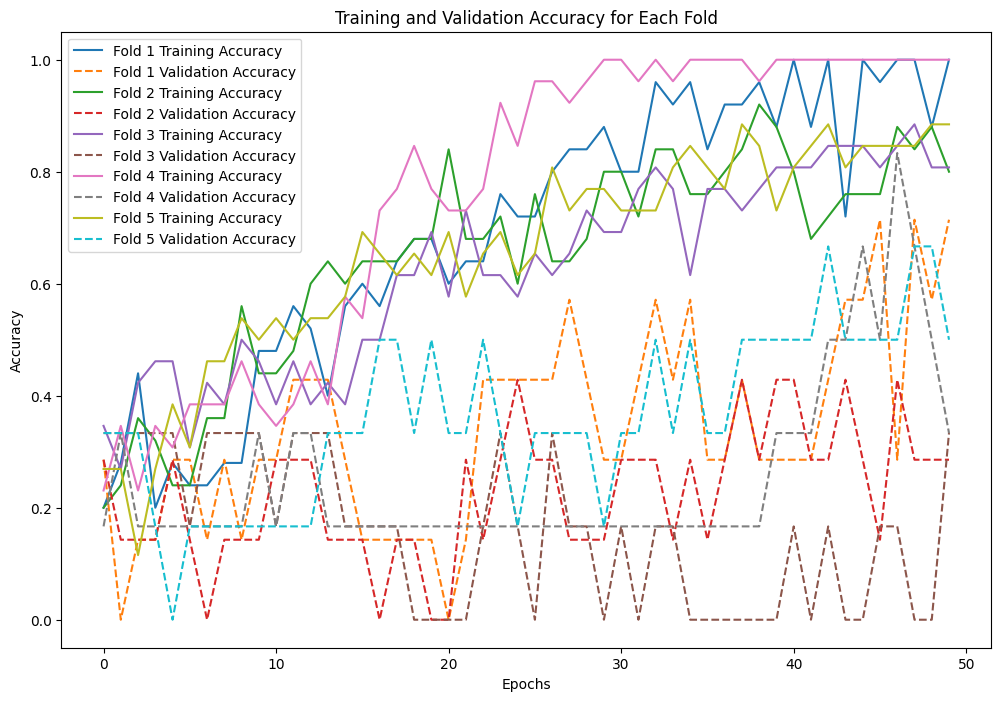

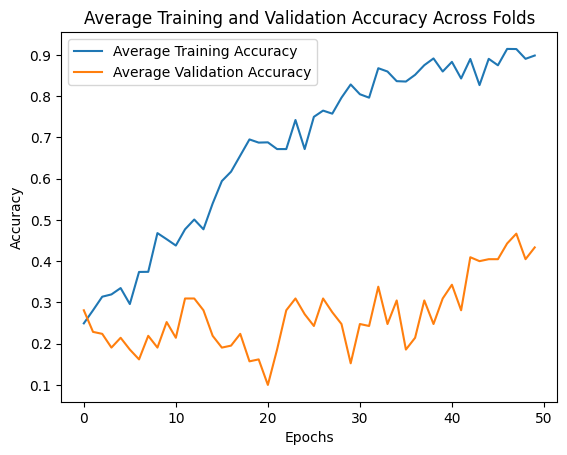

In [ ]:
# Plot training and validation accuracy for each fold
plt.figure(figsize=(12, 8))
for i in range(NUM_FOLDS):
    plt.plot(train_accuracy_history[i], label=f'Fold {i+1} Training Accuracy')
    plt.plot(val_accuracy_history[i], label=f'Fold {i+1} Validation Accuracy', linestyle='--')

plt.title('Training and Validation Accuracy for Each Fold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

# Calculate mean accuracy across folds for each epoch
mean_train_accuracy = np.mean(train_accuracy_history, axis=0)
mean_val_accuracy = np.mean(val_accuracy_history, axis=0)

# Plot average training and validation accuracy
plt.figure()
plt.plot(mean_train_accuracy, label='Average Training Accuracy')
plt.plot(mean_val_accuracy, label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# After cross-validation, create a new model and load the best weights
final_model = keras.Model(inputs=inputs, outputs=outputs)  # Same architecture as before
final_model.set_weights(best_weights)  # Load best weights from cross-validation

# Compile the final model
final_model.compile(
    loss="sparse_categorical_crossentropy",
    # optimizer=keras.optimizers.SGD(weight_decay=5e-4, learning_rate=schedule, momentum=0.9,),
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"]
)

# Combine the full dataset for fine-tuning
full_train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
full_train_dataset = full_train_dataset.map(lambda x, y: (x / 255.0, y))
full_train_dataset = full_train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Fine-tune the model on the full dataset
history =  final_model.fit(full_train_dataset, epochs=40)

Epoch 1/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.8125 - loss: 1.2223
Epoch 2/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.9062 - loss: 1.2245
Epoch 3/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9375 - loss: 1.1984
Epoch 4/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9375 - loss: 1.2141
Epoch 5/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9375 - loss: 1.2106
Epoch 6/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9375 - loss: 1.1932
Epoch 7/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9375 - loss: 1.1949
Epoch 8/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9062 - loss: 1.2330
Epoch 9/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9062 - loss: 1.2161
Epoch 10/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9062 - loss: 1.1983
Epoch 11/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.9375 - loss: 1.1870
Epoch 12/40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 1.0000 - loss: 

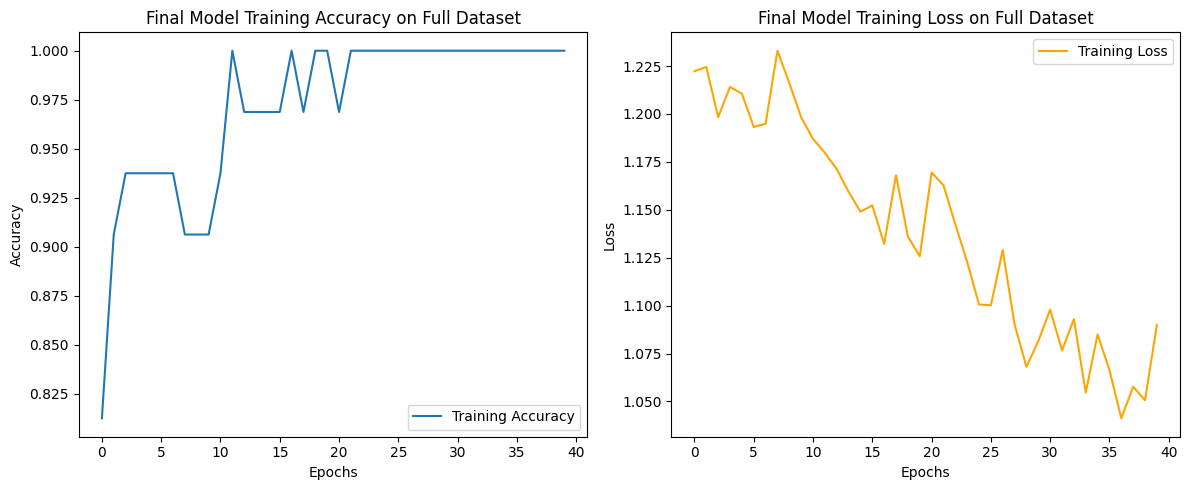

In [ ]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Final Model Training Accuracy on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.title('Final Model Training Loss on Full Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/3D/ttt/ttt",  # Path to test dataset
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'  # Use 'int' labels to match the training dataset
)

# Apply gamma transformation and normalize the test dataset
test_dataset = test_dataset.map(lambda x, y: (apply_gamma(x, gamma=GAMMA) / 255.0, y))  # Apply gamma and normalize

# Evaluate the final model on the test dataset
test_loss, test_accuracy = final_model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 32 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2188 - loss: 1.6229

Test Loss: 1.622878074645996
Test Accuracy: 0.21875
